In [11]:
from gerrychain import (GeographicPartition, Graph, MarkovChain,
                        updaters, Election, constraints, accept)
from gerrychain.proposals import recom
from functools import partial
import pandas as pd
import geopandas as gpd
import numpy as np
import statistics
import matplotlib.pyplot as plt

In [2]:
from gerrychain.random import random
random.seed(12345678)

In [3]:
la_graph = Graph.from_file("./la_election/la_election_shapefile.shp")

In [4]:
elections = [
    Election("SEN20", {"Democratic": "G20USSD", "Republican": "G20USSR"}),
    Election("PRES20", {"Democratic": "G20PRED", "Republican": "G20PRER"})
]

In [5]:
my_updaters = {"population": updaters.Tally("TOTPOP", alias="population")}
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

In [6]:
initial_partition = GeographicPartition(graph=la_graph, assignment="CD", updaters=my_updaters)

In [7]:
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

In [8]:
proposal = partial(recom, pop_col="TOTPOP", pop_target=ideal_population, epsilon=0.02, node_repeats=2)

In [9]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

In [10]:
pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

In [12]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[pop_constraint, compactness_bound],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=500
)

In [13]:
data = pd.DataFrame(
    sorted(partition["PRES20"].percents("Democratic"))
    for partition in chain.with_progress_bar()
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|███████████████████████████████████████████████████████████| 500/500 [03:06<00:00,  2.69it/s]


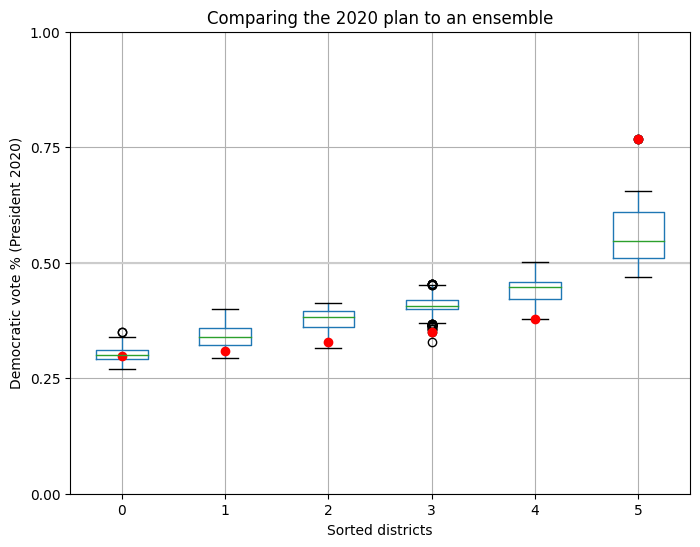

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data.boxplot(ax=ax, positions=range(len(data.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row, which corresponds to the initial plan)
plt.plot(data.iloc[0], "ro")

# Annotate
ax.set_title("Comparing the 2020 plan to an ensemble")
ax.set_ylabel("Democratic vote % (President 2020)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.show()

In [16]:
sen_data = pd.DataFrame(
    sorted(partition["SEN20"].percents("Democratic"))
    for partition in chain.with_progress_bar()
)

100%|███████████████████████████████████████████████████████████| 500/500 [03:12<00:00,  2.59it/s]


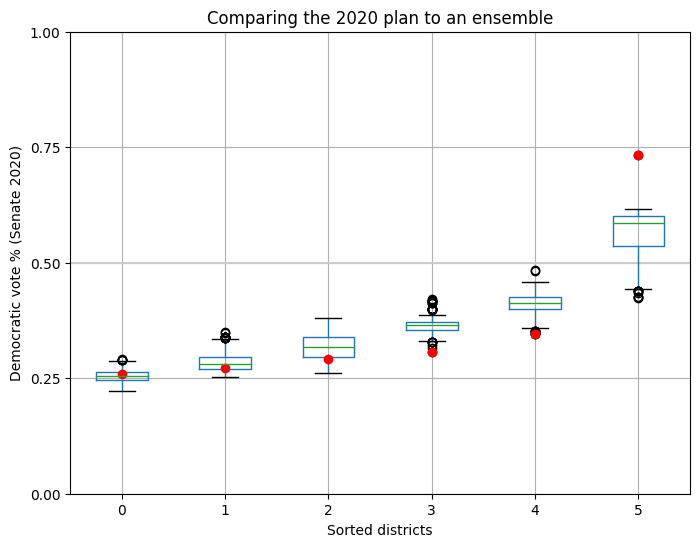

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
sen_data.boxplot(ax=ax, positions=range(len(sen_data.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row, which corresponds to the initial plan)
plt.plot(sen_data.iloc[0], "ro")

# Annotate
ax.set_title("Comparing the 2020 plan to an ensemble")
ax.set_ylabel("Democratic vote % (Senate 2020)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.show()